In [1]:
import tensorflow as tf
from tensorflow import keras as keras
print(tf.__version__)

print(keras.__version__)

2.3.1
2.4.0


In [2]:
# Wczytaj dane treningowe i testowe
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

train_set = pd.read_csv('Dane/adult/adult.data', sep=", ",header = None)
test_set = pd.read_csv('Dane/adult/adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

train = train_set.replace('?', np.nan).dropna()
test = test_set.replace('?', np.nan).dropna()

train_set.head()

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
dataset = pd.concat([train,test])

dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0,'<=50K':0, '>50K.':1, '>50K':1})

dataset.drop(["fnlwgt"],axis=1,inplace=True)

dataset.drop(["education"],axis=1,inplace=True)

x = dataset.groupby('native_country')["wage_class"].mean()

d = dict(pd.cut(x[x.index!=" United-States"],5,labels=range(5)))

dataset['native_country'] = dataset['native_country'].replace(d)

dataset = pd.get_dummies(dataset,drop_first=True)

train = dataset.iloc[:train.shape[0]]
test = dataset.iloc[train.shape[0]:]

X_train = train.drop("wage_class",axis=1)
y_train = train.wage_class

X_test = test.drop("wage_class",axis=1)
y_test = test.wage_class

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape)
X_test.shape

(30162, 41)


(15060, 41)

# EarlyStopping

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.callbacks import History

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate


history_Adam = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dense(50,activation="sigmoid"))
model.add(Dense(10,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

Adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="binary_crossentropy",optimizer=Adam, metrics=["accuracy"])

save_best_model = ModelCheckpoint("wagi_best.h5",save_best_only=True)
lrate = LearningRateScheduler(step_decay)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)

model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[lrate, history_Adam, save_best_model, early_stopping])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               4200      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 9,771
Trainable params: 9,771
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
943/943 [==============================] - 1s 1ms/step - loss: 0.3761 - accuracy: 0.8245 - val_loss: 0.3403 - val_accuracy: 0.8450
Epoch 2/100
943/943 [==============================] - 1s 1ms/step - loss: 0.3354 - accuracy: 0.8444 - val_lo

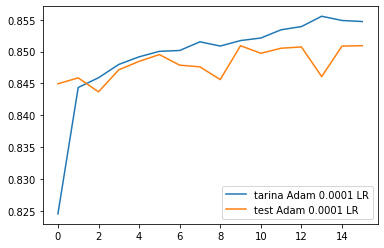

In [5]:
plt.plot(history_Adam.history['accuracy'], label = "tarina Adam 0.0001 LR")
plt.plot(history_Adam.history['val_accuracy'], label = "test Adam 0.0001 LR")


plt.legend()
plt.show()

In [7]:
model.load_weights("wagi_best.h5")
model.evaluate(X_test,y_test)

471/471 [==============================] - 0s 695us/step - loss: 0.3183 - accuracy: 0.8507


[0.3183056712150574, 0.8507304191589355]

# Zad.
Do poniższych danych dobierz paametr
```python
patience=
```

Zwizualizuj wyniki dla obu modeli.

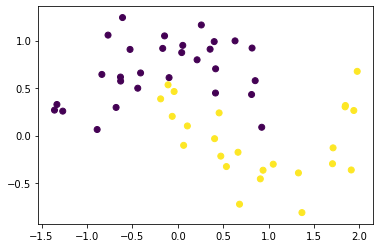

In [8]:
from sklearn.datasets import make_moons
# generate 2d classification dataset
X, y = make_moons(n_samples=100, noise=0.2, random_state=5)
# split into train and test
# n_train = 30
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70, random_state=2)

n_train=53
X_train, X_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]

plt.scatter(X_train[:,0],X_train[:,1], c=y_train)
plt.show()

In [9]:
from tensorflow.keras.callbacks import History


history_Adam = History()
model = Sequential()
model.add(Dense(1000,activation="relu",input_shape=(X_train.shape[1],)))
model.add(Dense(500,activation="sigmoid"))
model.add(Dense(200,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[history_Adam])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1000)              3000      
_________________________________________________________________
dense_5 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_6 (Dense)              (None, 200)               100200    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 201       
Total params: 603,901
Trainable params: 603,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
2/2 [==============================] - 0s 93ms/step - loss: 0.6684 - accuracy: 0.5849 - val_loss: 0.8367 - val_accuracy: 0.4468
Epoch 2/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.7171 - accuracy: 0.5472 - val_

2/2 [==============================] - 0s 14ms/step - loss: 0.1884 - accuracy: 0.9245 - val_loss: 0.4542 - val_accuracy: 0.8298
Epoch 53/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.1872 - accuracy: 0.9057 - val_loss: 0.4815 - val_accuracy: 0.8085
Epoch 54/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.1866 - accuracy: 0.9434 - val_loss: 0.4847 - val_accuracy: 0.8085
Epoch 55/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.1849 - accuracy: 0.9434 - val_loss: 0.4660 - val_accuracy: 0.8298
Epoch 56/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.1819 - accuracy: 0.9434 - val_loss: 0.4416 - val_accuracy: 0.8298
Epoch 57/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.1779 - accuracy: 0.9245 - val_loss: 0.4331 - val_accuracy: 0.8298
Epoch 58/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.1817 - accuracy: 0.9245 - val_loss: 0.4272 - val_accuracy: 0.8298
Epoch 59/1000
2/2 [=

Epoch 110/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0608 - accuracy: 0.9811 - val_loss: 0.2089 - val_accuracy: 0.9149
Epoch 111/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0611 - accuracy: 1.0000 - val_loss: 0.1991 - val_accuracy: 0.9149
Epoch 112/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0577 - accuracy: 1.0000 - val_loss: 0.1998 - val_accuracy: 0.9149
Epoch 113/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0547 - accuracy: 1.0000 - val_loss: 0.2057 - val_accuracy: 0.9149
Epoch 114/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0559 - accuracy: 0.9811 - val_loss: 0.2080 - val_accuracy: 0.9149
Epoch 115/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0533 - accuracy: 0.9811 - val_loss: 0.1997 - val_accuracy: 0.9149
Epoch 116/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0508 - accuracy: 1.0000 - val_loss: 0.1892 - val_accuracy: 0.9149

Epoch 167/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.0178 - accuracy: 1.0000 - val_loss: 0.1863 - val_accuracy: 0.9149
Epoch 168/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0183 - accuracy: 1.0000 - val_loss: 0.1948 - val_accuracy: 0.9362
Epoch 169/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0184 - accuracy: 1.0000 - val_loss: 0.1949 - val_accuracy: 0.9362
Epoch 170/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0172 - accuracy: 1.0000 - val_loss: 0.1911 - val_accuracy: 0.9149
Epoch 171/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0170 - accuracy: 1.0000 - val_loss: 0.1853 - val_accuracy: 0.8936
Epoch 172/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0185 - accuracy: 1.0000 - val_loss: 0.1848 - val_accuracy: 0.8936
Epoch 173/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0166 - accuracy: 1.0000 - val_loss: 0.1928 - val_accuracy: 0.9149

2/2 [==============================] - 0s 13ms/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.1989 - val_accuracy: 0.9149
Epoch 225/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.1996 - val_accuracy: 0.9149
Epoch 226/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0078 - accuracy: 1.0000 - val_loss: 0.2013 - val_accuracy: 0.9149
Epoch 227/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 0.2037 - val_accuracy: 0.9149
Epoch 228/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.2021 - val_accuracy: 0.9149
Epoch 229/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 0.1986 - val_accuracy: 0.9149
Epoch 230/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.1971 - val_accuracy: 0.9149
Epoch 231/1000

2/2 [==============================] - 0s 14ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.2214 - val_accuracy: 0.9149
Epoch 282/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.2186 - val_accuracy: 0.9149
Epoch 283/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.2173 - val_accuracy: 0.9149
Epoch 284/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.2179 - val_accuracy: 0.9149
Epoch 285/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.2190 - val_accuracy: 0.9149
Epoch 286/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.2181 - val_accuracy: 0.9149
Epoch 287/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.2176 - val_accuracy: 0.9149
Epoch 288/1000

2/2 [==============================] - 0s 13ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.2345 - val_accuracy: 0.9149
Epoch 339/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.2349 - val_accuracy: 0.9149
Epoch 340/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.2357 - val_accuracy: 0.9149
Epoch 341/1000
2/2 [==============================] - 0s 19ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.2367 - val_accuracy: 0.9149
Epoch 342/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.2385 - val_accuracy: 0.9149
Epoch 343/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.2384 - val_accuracy: 0.9149
Epoch 344/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.2383 - val_accuracy: 0.9149
Epoch 345/1000

2/2 [==============================] - 0s 13ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.2551 - val_accuracy: 0.9149
Epoch 396/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.2570 - val_accuracy: 0.9149
Epoch 397/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.2576 - val_accuracy: 0.9149
Epoch 398/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.2565 - val_accuracy: 0.9149
Epoch 399/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.2557 - val_accuracy: 0.9149
Epoch 400/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.2544 - val_accuracy: 0.9149
Epoch 401/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.2549 - val_accuracy: 0.9149
Epoch 402/1000

2/2 [==============================] - 0s 14ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.2781 - val_accuracy: 0.9149
Epoch 453/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.2776 - val_accuracy: 0.9149
Epoch 454/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.2746 - val_accuracy: 0.9149
Epoch 455/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2737 - val_accuracy: 0.9149
Epoch 456/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2738 - val_accuracy: 0.9149
Epoch 457/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2747 - val_accuracy: 0.9149
Epoch 458/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2770 - val_accuracy: 0.9149
Epoch 459/1000

Epoch 509/1000
2/2 [==============================] - 0s 13ms/step - loss: 8.9607e-04 - accuracy: 1.0000 - val_loss: 0.2963 - val_accuracy: 0.9149
Epoch 510/1000
2/2 [==============================] - 0s 14ms/step - loss: 8.9396e-04 - accuracy: 1.0000 - val_loss: 0.2971 - val_accuracy: 0.9149
Epoch 511/1000
2/2 [==============================] - 0s 15ms/step - loss: 8.9853e-04 - accuracy: 1.0000 - val_loss: 0.2973 - val_accuracy: 0.9149
Epoch 512/1000
2/2 [==============================] - 0s 18ms/step - loss: 8.8583e-04 - accuracy: 1.0000 - val_loss: 0.2960 - val_accuracy: 0.9149
Epoch 513/1000
2/2 [==============================] - 0s 19ms/step - loss: 9.0645e-04 - accuracy: 1.0000 - val_loss: 0.2946 - val_accuracy: 0.9149
Epoch 514/1000
2/2 [==============================] - 0s 14ms/step - loss: 8.5192e-04 - accuracy: 1.0000 - val_loss: 0.2946 - val_accuracy: 0.9149
Epoch 515/1000
2/2 [==============================] - 0s 13ms/step - loss: 8.4786e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 565/1000
2/2 [==============================] - 0s 20ms/step - loss: 6.9031e-04 - accuracy: 1.0000 - val_loss: 0.3149 - val_accuracy: 0.9149
Epoch 566/1000
2/2 [==============================] - 0s 18ms/step - loss: 6.6656e-04 - accuracy: 1.0000 - val_loss: 0.3142 - val_accuracy: 0.9149
Epoch 567/1000
2/2 [==============================] - 0s 18ms/step - loss: 7.0422e-04 - accuracy: 1.0000 - val_loss: 0.3128 - val_accuracy: 0.9149
Epoch 568/1000
2/2 [==============================] - 0s 14ms/step - loss: 6.9083e-04 - accuracy: 1.0000 - val_loss: 0.3125 - val_accuracy: 0.9149
Epoch 569/1000
2/2 [==============================] - 0s 15ms/step - loss: 6.8767e-04 - accuracy: 1.0000 - val_loss: 0.3138 - val_accuracy: 0.9149
Epoch 570/1000
2/2 [==============================] - 0s 14ms/step - loss: 6.5265e-04 - accuracy: 1.0000 - val_loss: 0.3146 - val_accuracy: 0.9149
Epoch 571/1000
2/2 [==============================] - 0s 13ms/step - loss: 6.6758e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 621/1000
2/2 [==============================] - 0s 16ms/step - loss: 5.4668e-04 - accuracy: 1.0000 - val_loss: 0.3278 - val_accuracy: 0.9149
Epoch 622/1000
2/2 [==============================] - 0s 12ms/step - loss: 5.2841e-04 - accuracy: 1.0000 - val_loss: 0.3288 - val_accuracy: 0.9149
Epoch 623/1000
2/2 [==============================] - 0s 13ms/step - loss: 5.4037e-04 - accuracy: 1.0000 - val_loss: 0.3300 - val_accuracy: 0.9149
Epoch 624/1000
2/2 [==============================] - 0s 12ms/step - loss: 5.2914e-04 - accuracy: 1.0000 - val_loss: 0.3305 - val_accuracy: 0.9149
Epoch 625/1000
2/2 [==============================] - 0s 14ms/step - loss: 5.1783e-04 - accuracy: 1.0000 - val_loss: 0.3305 - val_accuracy: 0.9149
Epoch 626/1000
2/2 [==============================] - 0s 18ms/step - loss: 5.3502e-04 - accuracy: 1.0000 - val_loss: 0.3297 - val_accuracy: 0.9149
Epoch 627/1000
2/2 [==============================] - 0s 15ms/step - loss: 5.2442e-04 - accuracy: 1.0000 - val_loss: 0

2/2 [==============================] - 0s 12ms/step - loss: 4.1911e-04 - accuracy: 1.0000 - val_loss: 0.3424 - val_accuracy: 0.9149
Epoch 677/1000
2/2 [==============================] - 0s 13ms/step - loss: 4.1799e-04 - accuracy: 1.0000 - val_loss: 0.3426 - val_accuracy: 0.9149
Epoch 678/1000
2/2 [==============================] - 0s 13ms/step - loss: 4.2350e-04 - accuracy: 1.0000 - val_loss: 0.3432 - val_accuracy: 0.9149
Epoch 679/1000
2/2 [==============================] - 0s 13ms/step - loss: 4.1919e-04 - accuracy: 1.0000 - val_loss: 0.3432 - val_accuracy: 0.9149
Epoch 680/1000
2/2 [==============================] - 0s 12ms/step - loss: 4.1426e-04 - accuracy: 1.0000 - val_loss: 0.3430 - val_accuracy: 0.9149
Epoch 681/1000
2/2 [==============================] - 0s 15ms/step - loss: 4.1920e-04 - accuracy: 1.0000 - val_loss: 0.3431 - val_accuracy: 0.9149
Epoch 682/1000
2/2 [==============================] - 0s 16ms/step - loss: 4.1718e-04 - accuracy: 1.0000 - val_loss: 0.3431 - val_acc

Epoch 732/1000
2/2 [==============================] - 0s 16ms/step - loss: 3.4343e-04 - accuracy: 1.0000 - val_loss: 0.3585 - val_accuracy: 0.8936
Epoch 733/1000
2/2 [==============================] - 0s 14ms/step - loss: 3.4925e-04 - accuracy: 1.0000 - val_loss: 0.3590 - val_accuracy: 0.8936
Epoch 734/1000
2/2 [==============================] - 0s 16ms/step - loss: 3.4814e-04 - accuracy: 1.0000 - val_loss: 0.3589 - val_accuracy: 0.8936
Epoch 735/1000
2/2 [==============================] - 0s 19ms/step - loss: 3.4723e-04 - accuracy: 1.0000 - val_loss: 0.3597 - val_accuracy: 0.8936
Epoch 736/1000
2/2 [==============================] - 0s 13ms/step - loss: 3.4504e-04 - accuracy: 1.0000 - val_loss: 0.3597 - val_accuracy: 0.8936
Epoch 737/1000
2/2 [==============================] - 0s 14ms/step - loss: 3.3668e-04 - accuracy: 1.0000 - val_loss: 0.3604 - val_accuracy: 0.8936
Epoch 738/1000
2/2 [==============================] - 0s 15ms/step - loss: 3.3839e-04 - accuracy: 1.0000 - val_loss: 0

2/2 [==============================] - 0s 17ms/step - loss: 2.8407e-04 - accuracy: 1.0000 - val_loss: 0.3720 - val_accuracy: 0.8936
Epoch 788/1000
2/2 [==============================] - 0s 17ms/step - loss: 2.8413e-04 - accuracy: 1.0000 - val_loss: 0.3722 - val_accuracy: 0.8936
Epoch 789/1000
2/2 [==============================] - 0s 14ms/step - loss: 2.8362e-04 - accuracy: 1.0000 - val_loss: 0.3723 - val_accuracy: 0.8936
Epoch 790/1000
2/2 [==============================] - 0s 13ms/step - loss: 2.8244e-04 - accuracy: 1.0000 - val_loss: 0.3723 - val_accuracy: 0.8936
Epoch 791/1000
2/2 [==============================] - 0s 14ms/step - loss: 2.8697e-04 - accuracy: 1.0000 - val_loss: 0.3722 - val_accuracy: 0.8936
Epoch 792/1000
2/2 [==============================] - 0s 15ms/step - loss: 2.8297e-04 - accuracy: 1.0000 - val_loss: 0.3725 - val_accuracy: 0.8936
Epoch 793/1000
2/2 [==============================] - 0s 16ms/step - loss: 2.7975e-04 - accuracy: 1.0000 - val_loss: 0.3729 - val_acc

Epoch 843/1000
2/2 [==============================] - 0s 14ms/step - loss: 2.3772e-04 - accuracy: 1.0000 - val_loss: 0.3823 - val_accuracy: 0.8936
Epoch 844/1000
2/2 [==============================] - 0s 17ms/step - loss: 2.4132e-04 - accuracy: 1.0000 - val_loss: 0.3823 - val_accuracy: 0.8936
Epoch 845/1000
2/2 [==============================] - 0s 16ms/step - loss: 2.3625e-04 - accuracy: 1.0000 - val_loss: 0.3829 - val_accuracy: 0.8936
Epoch 846/1000
2/2 [==============================] - 0s 16ms/step - loss: 2.3587e-04 - accuracy: 1.0000 - val_loss: 0.3833 - val_accuracy: 0.8936
Epoch 847/1000
2/2 [==============================] - 0s 15ms/step - loss: 2.4039e-04 - accuracy: 1.0000 - val_loss: 0.3838 - val_accuracy: 0.8936
Epoch 848/1000
2/2 [==============================] - 0s 13ms/step - loss: 2.3987e-04 - accuracy: 1.0000 - val_loss: 0.3838 - val_accuracy: 0.8936
Epoch 849/1000
2/2 [==============================] - 0s 14ms/step - loss: 2.3659e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 899/1000
2/2 [==============================] - 0s 12ms/step - loss: 2.0233e-04 - accuracy: 1.0000 - val_loss: 0.3929 - val_accuracy: 0.8936
Epoch 900/1000
2/2 [==============================] - 0s 16ms/step - loss: 2.0221e-04 - accuracy: 1.0000 - val_loss: 0.3933 - val_accuracy: 0.8936
Epoch 901/1000
2/2 [==============================] - 0s 13ms/step - loss: 2.0193e-04 - accuracy: 1.0000 - val_loss: 0.3935 - val_accuracy: 0.8936
Epoch 902/1000
2/2 [==============================] - 0s 13ms/step - loss: 2.0132e-04 - accuracy: 1.0000 - val_loss: 0.3935 - val_accuracy: 0.8936
Epoch 903/1000
2/2 [==============================] - 0s 14ms/step - loss: 2.0042e-04 - accuracy: 1.0000 - val_loss: 0.3936 - val_accuracy: 0.8936
Epoch 904/1000
2/2 [==============================] - 0s 13ms/step - loss: 2.0335e-04 - accuracy: 1.0000 - val_loss: 0.3935 - val_accuracy: 0.8936
Epoch 905/1000
2/2 [==============================] - 0s 14ms/step - loss: 2.0083e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 955/1000
2/2 [==============================] - 0s 15ms/step - loss: 1.7423e-04 - accuracy: 1.0000 - val_loss: 0.4019 - val_accuracy: 0.8936
Epoch 956/1000
2/2 [==============================] - 0s 16ms/step - loss: 1.7255e-04 - accuracy: 1.0000 - val_loss: 0.4025 - val_accuracy: 0.8936
Epoch 957/1000
2/2 [==============================] - 0s 15ms/step - loss: 1.7217e-04 - accuracy: 1.0000 - val_loss: 0.4030 - val_accuracy: 0.8936
Epoch 958/1000
2/2 [==============================] - 0s 13ms/step - loss: 1.7230e-04 - accuracy: 1.0000 - val_loss: 0.4034 - val_accuracy: 0.8936
Epoch 959/1000
2/2 [==============================] - 0s 23ms/step - loss: 1.7242e-04 - accuracy: 1.0000 - val_loss: 0.4036 - val_accuracy: 0.8936
Epoch 960/1000
2/2 [==============================] - 0s 13ms/step - loss: 1.7416e-04 - accuracy: 1.0000 - val_loss: 0.4036 - val_accuracy: 0.8936
Epoch 961/1000
2/2 [==============================] - 0s 16ms/step - loss: 1.7134e-04 - accuracy: 1.0000 - val_loss: 0

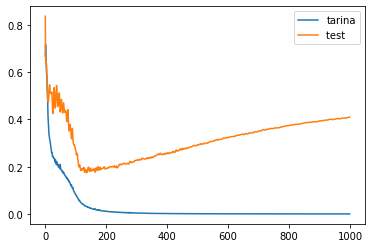

In [10]:
plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")


plt.legend()
plt.show()

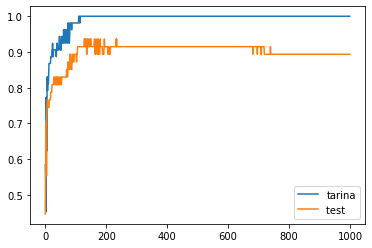

In [13]:
plt.plot(history_Adam.history['accuracy'], label = "tarina")
plt.plot(history_Adam.history['val_accuracy'], label = "test ")


plt.legend()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


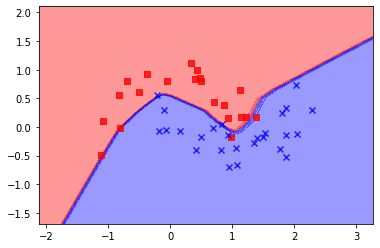

In [14]:
from help_plot import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()

# Zad

Do powyższego modelu dodaj EarlyStopping:

```python
early_stopping = EarlyStopping(monitor='val_loss', patience=50, mode='min', verbose=1)
```